<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/update_2023/10_Simulation_with_updated_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation with Updated Parameters

In this notebook, we'll implement the updated features we selected in the previous notebook. Rather than picking round numbers for the lookbacks, we'll randomly pick values around the parameters we looked at last time.

We'll do a simulation with rsims and find out if our trade buffer parameter needs updating.

First install libraries and load data:

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = TRUE, extra_libraries = c('lubridate', "glue", "tibbletime","roll","RcppRoll","Rcpp", "patchwork"), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




bit        (4.0.4 -> 4.0.5) [CRAN]
tidyselect (1.2.0 -> 1.2.1) [CRAN]


Installing 2 packages: bit, tidyselect

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



processx (3.8.3    -> 3.8.4 ) [CRAN]
callr    (3.7.3    -> 3.7.5 ) [CRAN]
pkgbuild (1.4.3    -> 1.4.4 ) [CRAN]
openssl  (2.0.6    -> 2.1.1 ) [CRAN]
curl     (5.0.2    -> 5.2.1 ) [CRAN]
gargle   (1.5.1    -> 1.5.2 ) [CRAN]
digest   (0.6.34   -> 0.6.35) [CRAN]
zip      (2.3.0    -> 2.3.1 ) [CRAN]
arrow    (13.0.0.1 -> 15.0.1) [CRAN]
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmpou4TDu/remotes25e6fbd3aca/RWLab-rwRtools-88f4072/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.67.tar.gz’

highr       (0.9   -> 0.10 ) [CRAN]
sass        (0.4.8 -> 0.4.9) [CRAN]
xfun        (0.41  -> 0.42 ) [CRAN]
tinytex     (0.49  -> 0.50 ) [CRAN]
textshaping (0.3.6 -> 0.3.7) [CRAN]
systemfonts (1.0.5 -> 1.0.6) [CRAN]
whisker 

In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

Authorization successful!

In [3]:
# snippet: rw crypto load coincodex data v0.1
market_cap <- rwRtools::crypto_get_coincodex() %>%
  select(Ticker, Date, MarketCapUSD)

# load binance prices
prices <- rwRtools::crypto_get_binance_spot_1h()

ℹ Downloading coincodex_marketcap.feather

✔ Saved coincodex_marketcap.feather to coincodex/coincodex_marketcap.feather  (…





File successfully transferred


ℹ Downloading binance_spot_1h.feather

✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 908.4 Mb )





File successfully transferred


Make our universe - daily prices snapshotted at 8am UTC:

In [4]:
#' prices: Binance hourly OHLCV spot data
create_binance_daily_snapshots <- function(prices, snapshot_hour=12) {
  prices %>%
    # retain only the data we need and ditch USDT part of Ticker
    select(Ticker, Datetime, Close) %>%
    mutate(Ticker = str_replace(Ticker, "USDT$", "")) %>%
   # take a daily snapshot at a particular time
    mutate(
      Hour = hour(Datetime),
      Date = as_date(Datetime)
    ) %>%
    filter(Hour == snapshot_hour) %>%
    select(Date, Ticker, Close)
}

#' market_cap: market cap data from coincodex
create_binance_universe <- function(prices, market_cap, n=10, min_constituents=10, stables, to_remove) {
  # Remove stablecoins and others
  prices <- prices %>%
    filter(!Ticker %in% c(stables, to_remove))

   # remove from market_cap data anything that wasn't trading on Binance or is a stable/duplicate
  binance_tickers <- pull(prices, Ticker)
  market_cap <- market_cap %>%
    filter(!Ticker %in% c(stables, to_remove)) %>%
    filter(Ticker %in% binance_tickers)

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(Date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(Date)) %>%
    pull(mindate)

  start_date <- start_date + 1

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  binance_universe <- prices %>%
    # this will remove any tickers that were removed from the prices data
    left_join(market_cap, by = c("Ticker", "Date")) %>%
    # where remaining tickers are missing market cap data, fill forward
    group_by(Ticker) %>%
    arrange(Date) %>%
    fill(MarketCapUSD, .direction = "down") %>%
    na.omit() %>%
    # but we need to create a new universe based on the remaining binance tickers (not all coincodex tickers were trading on binance)
    group_by(Date) %>%
    mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
    arrange(Date) %>%
    group_by(Ticker) %>%
    mutate(is_index = lag(cap_rank) <= n & Date >= start_date) %>%
    na.omit() %>%
    ungroup()
}

# create daily snapshots
daily_prices <- prices %>%
  create_binance_daily_snapshots(snapshot_hour = 8)

# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# duplicates and others to remove
to_remove <- c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC', 'BNBBULL', 'BNBBEAR', 'EOSBULL', 'EOSBEAR', 'ETHBULL', 'ETHBEAR', 'XRPBULL', 'XRPBEAR')

# create universe
min_constituents <- 10
universe <- create_binance_universe(daily_prices, market_cap, n=10, min_constituents=min_constituents, stables=stables, to_remove=to_remove)

head(universe)

Date,Ticker,Close,MarketCapUSD,cap_rank,is_index
<date>,<chr>,<dbl>,<dbl>,<int>,<lgl>
2017-08-17,BTC,4360.69,72153449099,1,FALSE
2017-08-17,ETH,308.62,28752742413,2,FALSE
2017-08-18,BTC,4282.73,70206129858,1,FALSE
2017-08-18,ETH,304.23,28406320026,2,FALSE
2017-08-19,BTC,3999.00,70206129858,1,FALSE
2017-08-19,ETH,288.40,28406320026,2,FALSE


## Cross-sectional momentum features

In [5]:
library(Rcpp)
cppFunction(
  code = 'NumericVector ema(NumericVector vec, int window) {
    double smoothing_factor = 2.0;
    double alpha = smoothing_factor/(window + 1);
    double beta = 1.0 - alpha;

    NumericVector ema = {vec[0]};
    if (vec.size() > 0 ) {
      for (int i = 1; i != vec.size(); ++i) { // Start iterating from  + 1 because I need the last value
          ema.push_back((vec[i] * alpha) + (ema[i-1] * beta));

        }
      return ema;
    }
}'
)

In [6]:
rolling_days_since_high_10 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 10, na_value = NA),
  otherwise = NA
)

mom_factor_wide <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Close momo factor
  mutate(
    x_mom_9 = log(Close / lag(Close, n = 9)),
    x_mom_13 = log(Close / lag(Close, n = 13)),
    x_mom_22 = log(Close / lag(Close, n = 22)),
  ) %>%
  # Close to SMA factor
  mutate(
    x_psma_11 = Close / roll_meanr(Close, 11) - 1,
    x_psma_19 = Close / roll_meanr(Close, 19) - 1,
    x_psma_33 = Close / roll_meanr(Close, 33) - 1,
  ) %>%
  # SMA ratio factor
  mutate(
    x_smaf_3_17 = roll_meanr(Close, 3) / roll_meanr(Close, 17) - 1,
    x_smaf_5_28 = roll_meanr(Close, 5) / roll_meanr(Close, 28) - 1,
  ) %>%
  # Range over recent history
  mutate(
    x_rrp_11 = (Close - roll_meanr(Close, n = 11)) / roll_sdr(Close, n = 11),
    x_rrp_18 = (Close - roll_meanr(Close, n = 18)) / roll_sdr(Close, n = 18),
    x_rrp_33 = (Close - roll_meanr(Close, n = 33)) / roll_sdr(Close, n = 33),
    x_rrp_41 = (Close - roll_meanr(Close, n = 41)) / roll_sdr(Close, n = 41),
  ) %>%
  # Range
  mutate(
    x_range_12 = (Close - roll_minr(Close, n = 12)) / (roll_maxr(Close, n = 12) - roll_minr(Close, n = 12)),
    x_range_20 = (Close - roll_minr(Close, n = 20)) / (roll_maxr(Close, n = 20) - roll_minr(Close, n = 20)),
    x_range_29 = (Close - roll_minr(Close, n = 29)) / (roll_maxr(Close, n = 29) - roll_minr(Close, n = 29)),
  ) %>%
  # Days since last high factor
  mutate(
    x_dsh_10 = -rolling_days_since_high_10(Close)
  ) %>%
  # Calculate returns
  mutate(
    fwd_return_1 = lead(Close,1) / Close - 1,
    fwd_return_2 = lead(Close,2) / lead(Close, 1) - 1,
    fwd_return_3 = lead(Close,3) / lead(Close, 2) - 1,
    fwd_log_return_1 = log(lead(Close) / Close),
    fwd_log_return_2 = log(lead(Close,2) / lead(Close, 1)),
    fwd_log_return_3 = log(lead(Close,3) / lead(Close, 2))
  ) %>%
  na.omit() %>%
  ungroup()

mom_ranks <- mom_factor_wide %>%
  pivot_longer(starts_with('x_'), names_to = 'feature', values_to = 'value') %>%
  filter(is_index) %>%
  group_by(Date, feature) %>%
  mutate(
    rank = row_number(value),
    weight = rank - mean(rank),
    scaled_weight = weight/sum(abs(weight)),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  )

mom_factor <- mom_ranks %>%
  group_by(Date, feature) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  group_by(feature) %>%
  arrange(Date) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  ) %>%
  # Rolling returns
  mutate(
    rolling_gap_0 = roll_meanr(log_factor_return_1, 90) * 365,
    rolling_gap_1 = roll_meanr(log_factor_return_2, 90) * 365,
    rolling_gap_2 = roll_meanr(log_factor_return_3, 90) * 365
  )

`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


Plot returns to momentum megafactor

`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


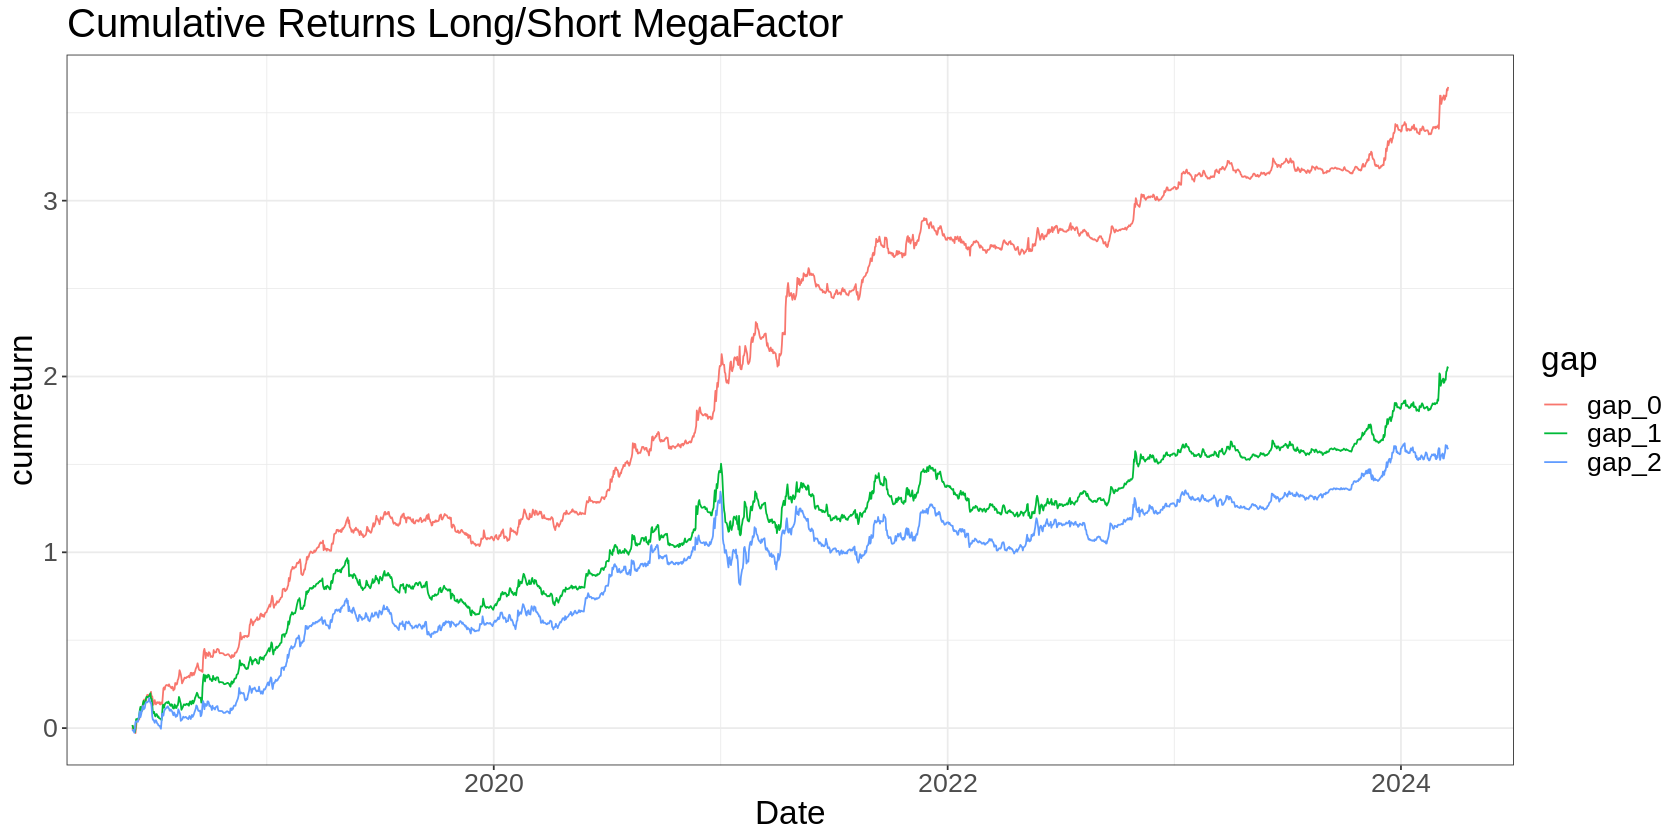

In [7]:
megafactor <- mom_ranks %>%
  group_by(Date, Ticker) %>%
  summarise(megafactor = mean(rank))

megafactor_cumreturns <- megafactor %>%
  inner_join(mom_factor_wide,  by = c('Ticker','Date')) %>%
  mutate(
    weight = megafactor - mean(megafactor),
    scaled_weight = weight/sum(abs(weight)),
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  ) %>%
  group_by(Date) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  arrange(Date) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  ) %>%
  # Rolling returns
  mutate(
    rolling_gap_0 = roll_meanr(log_factor_return_1, 90) * 365,
    rolling_gap_1 = roll_meanr(log_factor_return_2, 90) * 365,
    rolling_gap_2 = roll_meanr(log_factor_return_3, 90) * 365
  )

megafactor_cumreturns %>%
  pivot_longer(starts_with('gap_'), names_to = 'gap', values_to = 'cumreturn') %>%
  ggplot(aes(x=Date, y=cumreturn, color = gap)) +
    geom_line() +
    ggtitle('Cumulative Returns Long/Short MegaFactor')

## Time series trend features

In [8]:
rolling_days_since_high_12 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 12, na_value = NA),
  otherwise = NA
)

rolling_days_since_high_26 <- purrr::possibly(
  tibbletime::rollify(
    function(x) {
      idx_of_high <- which.max(x)
      days_since_high <- length(x) - idx_of_high
      days_since_high
    },
    window = 26, na_value = NA),
  otherwise = NA
)

trend_factor_wide <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Price momo factor
  mutate(
    t_mom_23 = log(Close / lag(Close, n = 23)),
    t_mom_32 = log(Close / lag(Close, n = 32)),
  ) %>%
  # Price to SMA factor
  mutate(
    t_psma_18 = Close / roll_meanr(Close, 18) - 1,
    t_psma_29 = Close / roll_meanr(Close, 29) - 1,
    t_psma_43 = Close / roll_meanr(Close, 43) - 1,
  ) %>%
  # SMA ratio factor
  mutate(
    t_smaf_3_13 = roll_meanr(Close, 3) / roll_meanr(Close, 13) - 1,
    t_smaf_3_24 = roll_meanr(Close, 3) / roll_meanr(Close, 24) - 1,
  ) %>%
  # Range over recent history
  mutate(
    t_rrp_8 = (Close - roll_meanr(Close, n = 8)) / roll_sdr(Close, n = 8),
    t_rrp_17 = (Close - roll_meanr(Close, n = 17)) / roll_sdr(Close, n = 17),
    t_rrp_31 = (Close - roll_meanr(Close, n = 31)) / roll_sdr(Close, n = 31),
    t_rrp_38 = (Close - roll_meanr(Close, n = 38)) / roll_sdr(Close, n = 38),
  ) %>%
  # Range
  mutate(
    t_range_10 = (Close - roll_minr(Close, n = 10)) / (roll_maxr(Close, n = 10) - roll_minr(Close, n = 10)) - 0.5,
    t_range_21 = (Close - roll_minr(Close, n = 21)) / (roll_maxr(Close, n = 21) - roll_minr(Close, n = 21)) - 0.5,
    t_range_33 = (Close - roll_minr(Close, n = 33)) / (roll_maxr(Close, n = 33) - roll_minr(Close, n = 33)) - 0.5,
  ) %>%
  # Days since last high factor
  mutate(
    t_dsh_12 = -rolling_days_since_high_10(Close) + 6
  ) %>%
  mutate(
    t_dsh_26 = -rolling_days_since_high_26(Close) + 13
  ) %>%
  # Calculate returns
  mutate(
    fwd_return_1 = lead(Close, 1) / Close - 1,
    fwd_return_2 = lead(Close, 2) / lead(Close, 1) - 1,
    fwd_return_3 = lead(Close, 3) / lead(Close, 2) - 1,
    fwd_log_return_1 = log(lead(Close) / Close),
    fwd_log_return_2 = log(lead(Close, 2) / lead(Close, 1)),
    fwd_log_return_3 = log(lead(Close, 3) / lead(Close, 2))
  ) %>%
  na.omit() %>%
  ungroup()

clamp <- 2.5
trend_ranks <- trend_factor_wide %>%
  pivot_longer(starts_with('t_'), names_to = 'feature', values_to = 'value') %>%
  group_by(Ticker, feature) %>%
  arrange(Date) %>%
  mutate(
    sd_scalemom = value / roll_sdr(value, 60),
    weight = 0.5 * pmax(pmin(sd_scalemom, clamp), -clamp),  # Scale to sit between 1.25 and -1.25
    scaled_weight = 0.1 * weight,                           # 10 assets so divide by 10
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  ) %>%
  filter(is_index) %>%
  na.omit() %>%
  ungroup()

trend_factor <- trend_ranks %>%
  filter(is_index) %>%
  group_by(Date, feature) %>%
  summarise(
    weight = sum(scaled_weight),
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  group_by(feature) %>%
  arrange(Date) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  ) %>%
  # Rolling returns
  mutate(
    rolling_gap_0 = roll_meanr(log_factor_return_1, 90) * 365,
    rolling_gap_1 = roll_meanr(log_factor_return_2, 90) * 365,
    rolling_gap_2 = roll_meanr(log_factor_return_3, 90) * 365
  )

`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


Plot returns to trend factor

`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


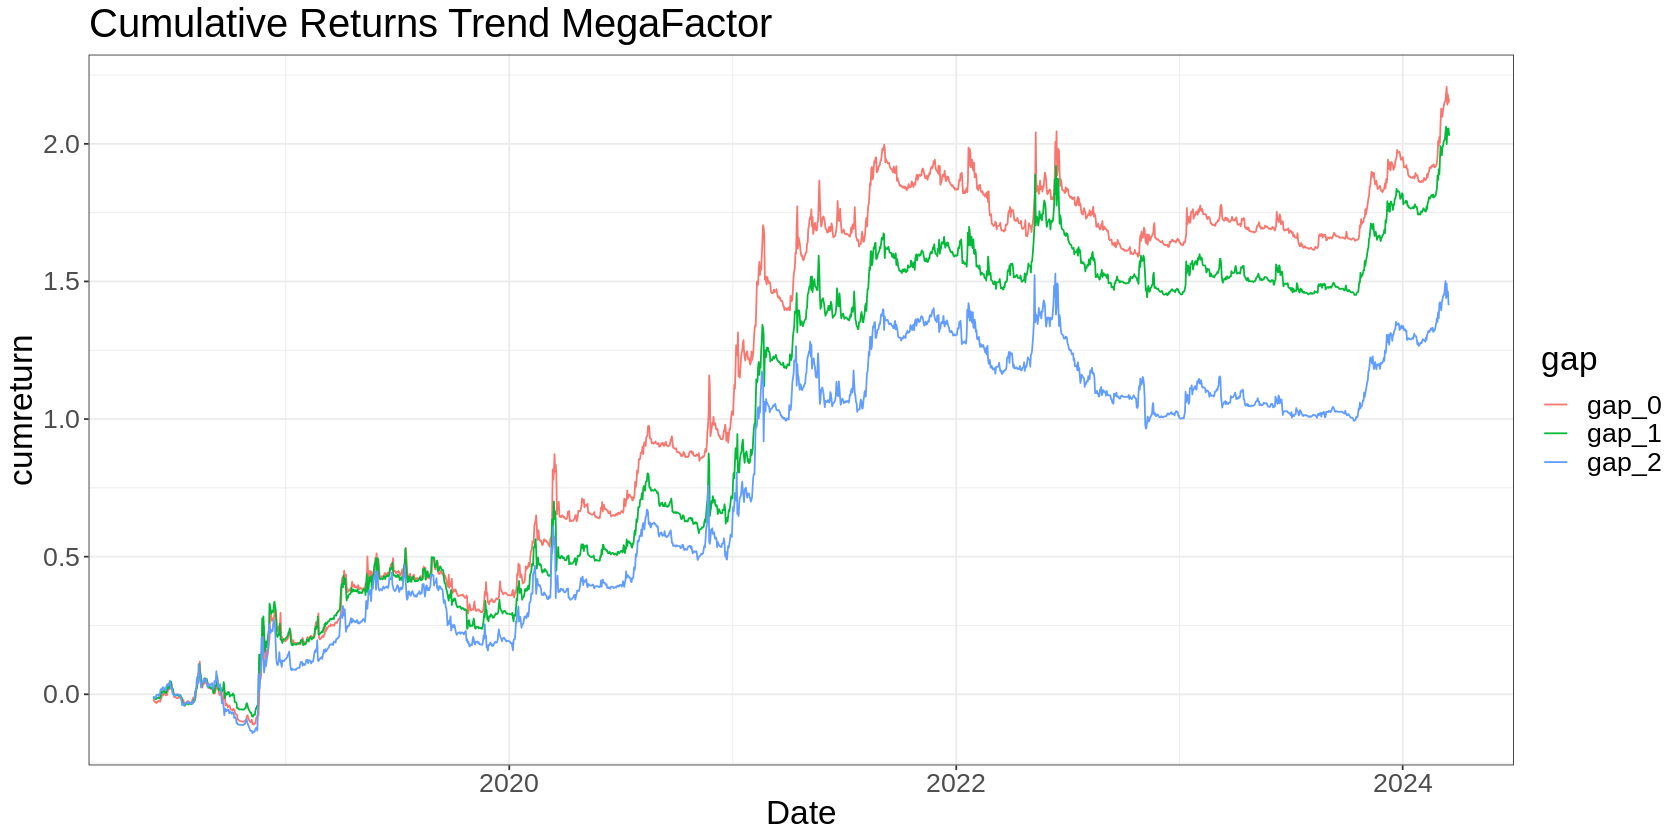

In [9]:
trend_weights <- trend_ranks %>%
  group_by(Date, Ticker) %>%
  summarise(scaled_weight = mean(scaled_weight))

trend_weights %>%
  inner_join(trend_factor_wide,  by = c('Ticker','Date')) %>%
  mutate(
    weighted_fwd_return_1 = fwd_return_1 * scaled_weight,
    weighted_fwd_return_2 = fwd_return_2 * scaled_weight,
    weighted_fwd_return_3 = fwd_return_3 * scaled_weight
  ) %>%
  group_by(Date) %>%
  summarise(
    log_factor_return_1 = log(sum(weighted_fwd_return_1) + 1),
    log_factor_return_2 = log(sum(weighted_fwd_return_2) + 1),
    log_factor_return_3 = log(sum(weighted_fwd_return_3) + 1)
  ) %>%
  arrange(Date) %>%
  # Cumulative Returns
  mutate(
    gap_0 = cumsum(log_factor_return_1),
    gap_1 = cumsum(log_factor_return_2),
    gap_2 = cumsum(log_factor_return_3)
  ) %>%
  # Rolling returns
  mutate(
    rolling_gap_0 = roll_meanr(log_factor_return_1, 90) * 365,
    rolling_gap_1 = roll_meanr(log_factor_return_2, 90) * 365,
    rolling_gap_2 = roll_meanr(log_factor_return_3, 90) * 365
  ) %>%
  pivot_longer(starts_with('gap_'), names_to = 'gap', values_to = 'cumreturn') %>%
  ggplot(aes(x=Date, y=cumreturn, color = gap)) +
    geom_line() +
    ggtitle('Cumulative Returns Trend MegaFactor')

## Trend and momentum together

I like the idea of upweighting the cross-sectional momentum component and downweighting the trend component. I want the trend component to just tilt the portfolio around a bit so that I get a little "trend following on the asset class" generally.

## rsims simulation

Recreate factors without removing rows, then get prices and weights as wide matrixes:

In [10]:
# recreate trend and momentum factors without removing rows due to missing forward returns
mom_factor_wide <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Close momo factor
  mutate(
    x_mom_9 = log(Close / lag(Close, n = 9)),
    x_mom_13 = log(Close / lag(Close, n = 13)),
    x_mom_22 = log(Close / lag(Close, n = 22)),
  ) %>%
  # Close to SMA factor
  mutate(
    x_psma_11 = Close / roll_meanr(Close, 11) - 1,
    x_psma_19 = Close / roll_meanr(Close, 19) - 1,
    x_psma_33 = Close / roll_meanr(Close, 33) - 1,
  ) %>%
  # SMA ratio factor
  mutate(
    x_smaf_3_17 = roll_meanr(Close, 3) / roll_meanr(Close, 17) - 1,
    x_smaf_5_28 = roll_meanr(Close, 5) / roll_meanr(Close, 28) - 1,
  ) %>%
  # Range over recent history
  mutate(
    x_rrp_11 = (Close - roll_meanr(Close, n = 11)) / roll_sdr(Close, n = 11),
    x_rrp_18 = (Close - roll_meanr(Close, n = 18)) / roll_sdr(Close, n = 18),
    x_rrp_33 = (Close - roll_meanr(Close, n = 33)) / roll_sdr(Close, n = 33),
    x_rrp_41 = (Close - roll_meanr(Close, n = 41)) / roll_sdr(Close, n = 41),
  ) %>%
  # Range
  mutate(
    x_range_12 = (Close - roll_minr(Close, n = 12)) / (roll_maxr(Close, n = 12) - roll_minr(Close, n = 12)),
    x_range_20 = (Close - roll_minr(Close, n = 20)) / (roll_maxr(Close, n = 20) - roll_minr(Close, n = 20)),
    x_range_29 = (Close - roll_minr(Close, n = 29)) / (roll_maxr(Close, n = 29) - roll_minr(Close, n = 29)),
  ) %>%
  # Days since last high factor
  mutate(
    x_dsh_10 = -rolling_days_since_high_10(Close)
  )
  momentum_megafactor <- mom_factor_wide %>%
  pivot_longer(starts_with('x_'), names_to = 'feature', values_to = 'value') %>%
  filter(is_index) %>%
  group_by(Date, feature) %>%
  mutate(
    rank = row_number(value),
    weight = rank - mean(rank),
    scaled_weight = weight/sum(abs(weight))
  ) %>%
  group_by(Date, Ticker) %>%
  summarise(megafactor = mean(rank, na.rm = TRUE))

trend_factor_wide <- universe %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Price momo factor
  mutate(
    t_mom_23 = log(Close / lag(Close, n = 23)),
    t_mom_32 = log(Close / lag(Close, n = 32)),
  ) %>%
  # Price to SMA factor
  mutate(
    t_psma_18 = Close / roll_meanr(Close, 18) - 1,
    t_psma_29 = Close / roll_meanr(Close, 29) - 1,
    t_psma_43 = Close / roll_meanr(Close, 43) - 1,
  ) %>%
  # SMA ratio factor
  mutate(
    t_smaf_3_13 = roll_meanr(Close, 3) / roll_meanr(Close, 13) - 1,
    t_smaf_3_24 = roll_meanr(Close, 3) / roll_meanr(Close, 24) - 1,
  ) %>%
  # Range over recent history
  mutate(
    t_rrp_8 = (Close - roll_meanr(Close, n = 8)) / roll_sdr(Close, n = 8),
    t_rrp_17 = (Close - roll_meanr(Close, n = 17)) / roll_sdr(Close, n = 17),
    t_rrp_31 = (Close - roll_meanr(Close, n = 31)) / roll_sdr(Close, n = 31),
    t_rrp_38 = (Close - roll_meanr(Close, n = 38)) / roll_sdr(Close, n = 38),
  ) %>%
  # Range
  mutate(
    t_range_10 = (Close - roll_minr(Close, n = 10)) / (roll_maxr(Close, n = 10) - roll_minr(Close, n = 10)) - 0.5,
    t_range_21 = (Close - roll_minr(Close, n = 21)) / (roll_maxr(Close, n = 21) - roll_minr(Close, n = 21)) - 0.5,
    t_range_33 = (Close - roll_minr(Close, n = 33)) / (roll_maxr(Close, n = 33) - roll_minr(Close, n = 33)) - 0.5,
  ) %>%
  # Days since last high factor
  mutate(
    t_dsh_12 = -rolling_days_since_high_10(Close) + 6
  ) %>%
  mutate(
    t_dsh_26 = -rolling_days_since_high_26(Close) + 13
  )

clamp <- 2.5
trend_megafactor <- trend_factor_wide %>%
  pivot_longer(starts_with('t_'), names_to = 'feature', values_to = 'value') %>%
  group_by(Ticker, feature) %>%
  arrange(Date) %>%
  mutate(
    sd_scalemom = value / roll_sdr(value, 60),
    weight = 0.5 * pmax(pmin(sd_scalemom, clamp), -clamp),  # Scale to sit between 1.25 and -1.25
    scaled_weight = 0.1 * weight
  ) %>%
  filter(is_index) %>%
  ungroup() %>%
  group_by(Date, Ticker) %>%
  summarise(trend_weight = mean(scaled_weight, na.rm = TRUE))

# but now we can get NaN factor values when we don't have enough history. Set to 0 (this will mean we only trade momo on these tickers on these dates). Set to NA to not trade these tickers at all.
trend_megafactor$trend_weight[is.nan(trend_megafactor$trend_weight)] <- 0

# this will give us mean ranks for each ticker each day that is in the tradable universe
# later will need to add in zero weights for anything that's not in the universe
momo_weight_scale <- 0.5
trend_weight_scale <- 0.5

comboweight <- momentum_megafactor %>%
  inner_join(trend_megafactor, by = c('Ticker','Date')) %>%
  mutate(
    momentum_weight_raw = megafactor - mean(megafactor, na.rm = TRUE), # ignore NA so that we can get factor values on days even one one ticker has a NA
    momentum_weight = momentum_weight_raw/sum(abs(momentum_weight_raw))
  ) %>%
  mutate(combo_weight = (momentum_weight * momo_weight_scale) + (trend_weight * trend_weight_scale)) %>%
  # na.omit() %>%
  # join closing prices
  left_join(universe %>% select(Date, Ticker, Close), by = c("Date", "Ticker"))

`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


In [11]:
head(comboweight)

Date,Ticker,megafactor,trend_weight,momentum_weight_raw,momentum_weight,combo_weight,Close
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-05-29,ADA,4.3750,0.00000000,0.002840909,0.0004748338,0.0002374169,0.18936
2018-05-29,BNB,5.6250,-0.05730293,1.252840909,0.2094017094,0.0760493916,11.83360
2018-05-29,BTC,4.7500,-0.05800825,0.377840909,0.0631528965,0.0025723220,7132.47000
2018-05-29,ETH,2.3125,-0.05670352,-2.059659091,-0.3442545109,-0.2004790137,520.86000
2018-05-29,LTC,5.3750,-0.06073311,1.002840909,0.1676163343,0.0534416125,112.79000
2018-05-29,NEO,3.9375,-0.05543871,-0.434659091,-0.0726495726,-0.0640441424,48.54000


In [12]:
comboweight %>%
  na.omit() %>%
  ungroup() %>%
  summarise(
    start = first(Date)
  )

start
<date>
2018-05-29


In [13]:
# get all tickers that were ever in the universe
universe_tickers <- universe %>%
  filter(is_index == TRUE) %>%
  pull(Ticker) %>%
  unique()

print(universe_tickers)

# get start date of simulation (first time we have factors for min constituents)
start_date <- comboweight %>%
  na.omit() %>%
  ungroup() %>%
  summarise(
    start = first(Date)
  ) %>%
  pull(start)

sim_df <- comboweight %>%
  select(Date, Ticker, Close, combo_weight) %>%
  # bind prices on days where our universe tickers weren't in the tradable universe
  # this will assign NA to any combo_weight where the ticker wasn't traded
  bind_rows(
    universe %>%
      filter(Ticker %in% universe_tickers, is_index == FALSE) %>%
      select(Date, Ticker, Close)
  ) %>%
  # assign 0 for any NA combo_weight
  replace_na(list(combo_weight = 0)) %>%
  # sort by date
  arrange(Date, Ticker) %>%
  # remove rows prior to start date
  filter(Date >= start_date)

head(sim_df)

 [1] "ADA"   "BNB"   "BTC"   "ETH"   "LTC"   "NEO"   "QTUM"  "XRP"   "EOS"  
[10] "XLM"   "ONT"   "TRX"   "ETC"   "BCHSV" "XMR"   "LINK"  "XTZ"   "BCH"  
[19] "DASH"  "DOT"   "DOGE"  "THETA" "FIL"   "UNI"   "ICP"   "SOL"   "AVAX" 
[28] "FLOW"  "SHIB"  "MATIC"


Date,Ticker,Close,combo_weight
<date>,<chr>,<dbl>,<dbl>
2018-05-29,ADA,0.18936,0.0002374169
2018-05-29,BNB,11.83360,0.0760493916
2018-05-29,BTC,7132.47000,0.0025723220
2018-05-29,ETH,520.86000,-0.2004790137
2018-05-29,LTC,112.79000,0.0534416125
2018-05-29,NEO,48.54000,-0.0640441424


In [14]:
# get weights as a wide matrix (could do equal weight, in proportion to factor/signal, top n etc)
# note that date column will get converted to unix timestamp
backtest_weights <- sim_df %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = c(Close, combo_weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(Date, starts_with("combo_weight")) %>%
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

head(backtest_weights, c(5, 5))

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- sim_df %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = c(Close, combo_weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(Date, starts_with("Close_")) %>%
  data.matrix()

head(backtest_prices, c(5, 5))

Date,combo_weight_ADA,combo_weight_BNB,combo_weight_BTC,combo_weight_ETH
17680,0.0002374169,0.07604939,0.002572322,-0.200479
17681,0.0000000000,0.00000000,0.000000000,0.000000
17682,0.0000000000,0.00000000,0.000000000,0.000000
17683,0.0000000000,0.00000000,0.000000000,0.000000
17684,0.0000000000,0.00000000,0.000000000,0.000000


Date,Close_ADA,Close_BNB,Close_BTC,Close_ETH
17680,0.18936,11.8336,7132.47,520.86
17681,0.20388,12.4556,7471.00,560.98
17682,0.21392,13.8121,7544.00,570.73
17683,0.22603,14.1677,7595.00,588.80
17684,0.22536,14.2892,7662.03,595.27


Useful functions and objects

In [15]:
# fees - reasonable approximation of actual binance costs (spread + market impact + commission)
fees <- tribble(
  ~tier, ~fee,
  0, 0.,  # use for cost-free simulations
  1, 0.0015,
  2, 0.001,
  3, 0.0008,
  4, 0.0007,
  5, 0.0006,
  6, 0.0004,
  7, 0.0002
)

# plot equity curve from output of simulation
plot_results <- function(backtest_results, weighting_protocol = "Long-short in proportion to factor rank", trade_on = "close") {
  equity_curve <- backtest_results %>%
    group_by(Date) %>%
    summarise(Equity = sum(Value, na.rm = TRUE))

  fin_eq <- equity_curve %>%
    tail(1) %>%
    pull(Equity)

  init_eq <- equity_curve %>%
    head(1) %>%
    pull(Equity)

  total_return <- (fin_eq/init_eq - 1) * 100
  days <- nrow(equity_curve)
  ann_return <- total_return * 365/days
  sharpe <- equity_curve %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()

  equity_curve %>%
    ggplot(aes(x = Date, y = Equity)) +
      geom_line() +
      labs(
        title = "Momentum Backtest - Cash Accounting",
        subtitle = glue(
          "{weighting_protocol}, costs {commission_pct*100}% trade value, trade buffer = {trade_buffer}, trade on {trade_on}
          {round(total_return, 1)}% total return, {round(ann_return, 1)}% annualised, Sharpe {round(sharpe, 2)}"
        )
      )
}

# calculate sharpe ratio from output of simulation
calc_sharpe <- function(backtest_results) {
  backtest_results %>%
    group_by(Date) %>%
    summarise(Equity = sum(Value, na.rm = TRUE)) %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()
}

## Cost free, no trade buffer parameter

ticker,Date,Close,Position,Value,Trades,TradeValue,Commission
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cash,2018-05-29,1.00000,1.166031e+04,11660.308105,NA,NA,0
ADA,2018-05-29,0.18936,1.253786e+01,2.374169,12.537859320,2.374169,0
BNB,2018-05-29,11.83360,6.426564e+01,760.493916,64.265643290,760.493916,0
BTC,2018-05-29,7132.47000,3.606495e-03,25.723220,0.003606495,25.723220,0
ETH,2018-05-29,520.86000,-3.849000e+00,-2004.790137,-3.848999995,-2004.790137,0
LTC,2018-05-29,112.79000,4.738152e+00,534.416125,4.738151653,534.416125,0


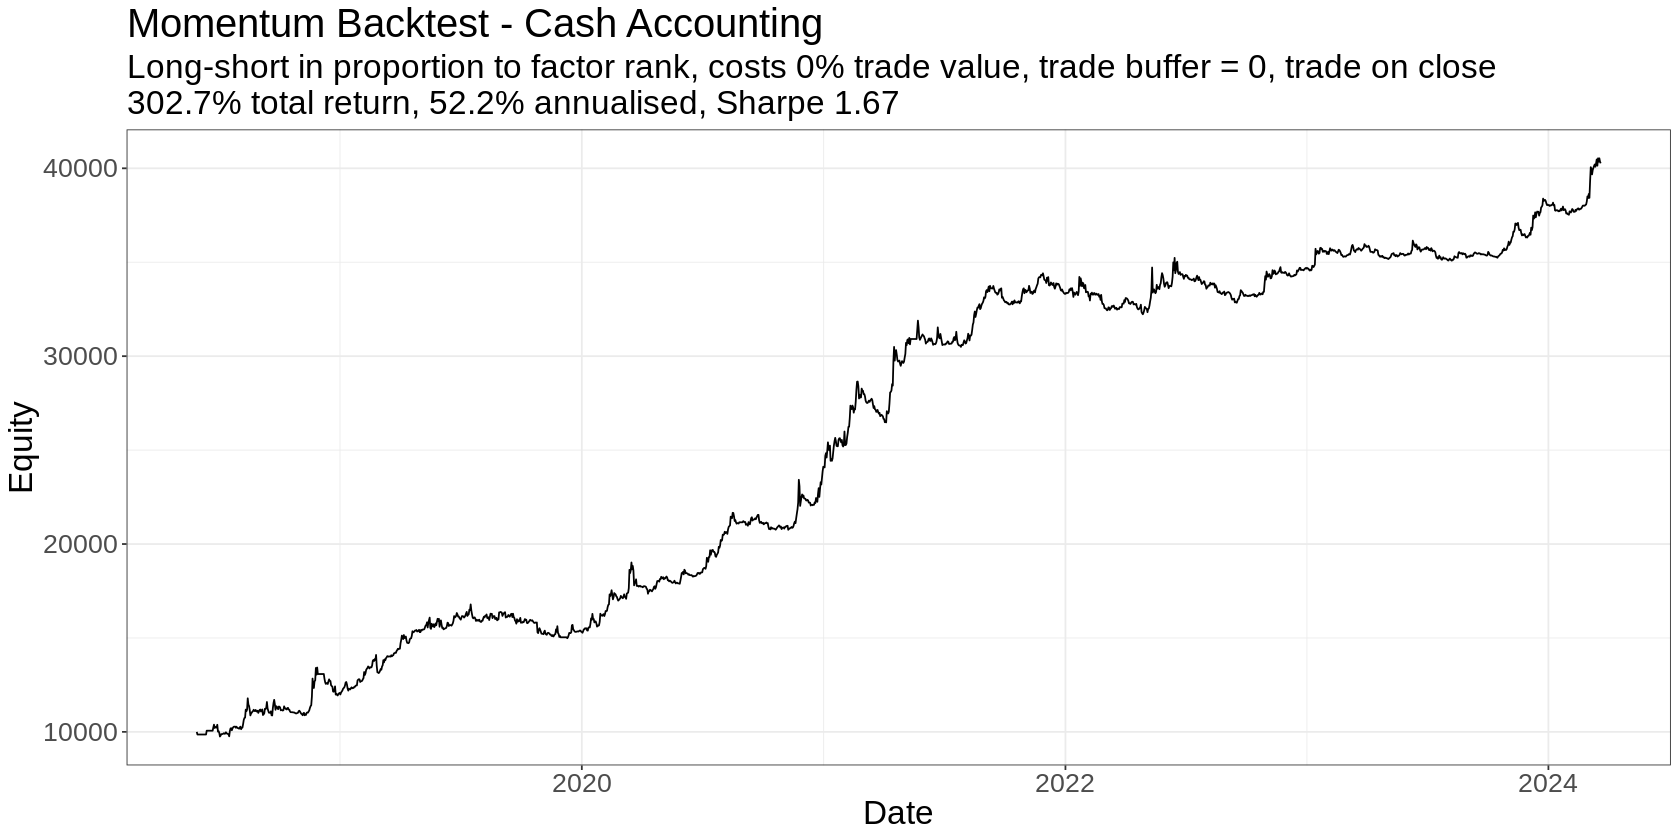

In [16]:
# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
fee_tier <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(backtest_prices, backtest_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits) %>%
  mutate(ticker = str_remove(ticker, "Close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

head(results_df)

plot_results(results_df)  # %>% filter(Date >= "2023-10-01"))

In [17]:
# XTZ comes into our universe on 25 Nov 2019
# BUT I believe we don't have trend factor values for it because it hasn't been around long enough to calculate the features - it comes into our price data on 27 Sep 2019
# What we'd probably want to do here is trade the top ten by market cap for which we have viable features - which is what we do in production


Small improvement over original features, as you'd expect (found by re-running notebooks 5b and 7 over the same period).

In [18]:
# check that actual weights match intended (can trade factional coins, so should be equal)
results_df %>%
  left_join(comboweight %>% select(Ticker, Date, combo_weight), by = c("ticker"="Ticker", "Date")) %>%
  group_by(Date) %>%
  mutate(
    actual_weight = Value/(initial_cash)
  )  %>%
  drop_na(combo_weight) %>%
  tail(10)

ticker,Date,Close,Position,Value,Trades,TradeValue,Commission,combo_weight,actual_weight
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADA,2024-03-20,6.015000e-01,-1.577120e+03,-948.6374,1.210680e+02,72.82241,0,-0.09486374,-0.09486374
BNB,2024-03-20,5.228000e+02,1.394182e+00,728.8784,4.766441e-02,24.91896,0,0.07288784,0.07288784
BTC,2024-03-20,6.268471e+04,-1.955829e-03,-122.6005,-2.091546e-03,-131.10793,0,-0.01226005,-0.01226005
ETH,2024-03-20,3.207790e+03,-2.267705e-01,-727.4321,-3.287676e-02,-105.46174,0,-0.07274321,-0.07274321
XRP,2024-03-20,5.908000e-01,-1.915112e+02,-113.1448,2.399221e+02,141.74595,0,-0.01131448,-0.01131448
TRX,2024-03-20,1.148300e-01,-1.020940e+04,-1172.3450,-2.583142e+03,-296.62221,0,-0.11723450,-0.11723450
DOGE,2024-03-20,1.322100e-01,-2.138241e+03,-282.6969,1.567594e+03,207.25159,0,-0.02826969,-0.02826969
SOL,2024-03-20,1.710100e+02,7.658072e+00,1309.6069,4.461236e-01,76.29160,0,0.13096069,0.13096069
AVAX,2024-03-20,5.258000e+01,2.125459e+01,1117.5662,-2.905600e+00,-152.77646,0,0.11175662,0.11175662


### With costs, no trade buffer parameter

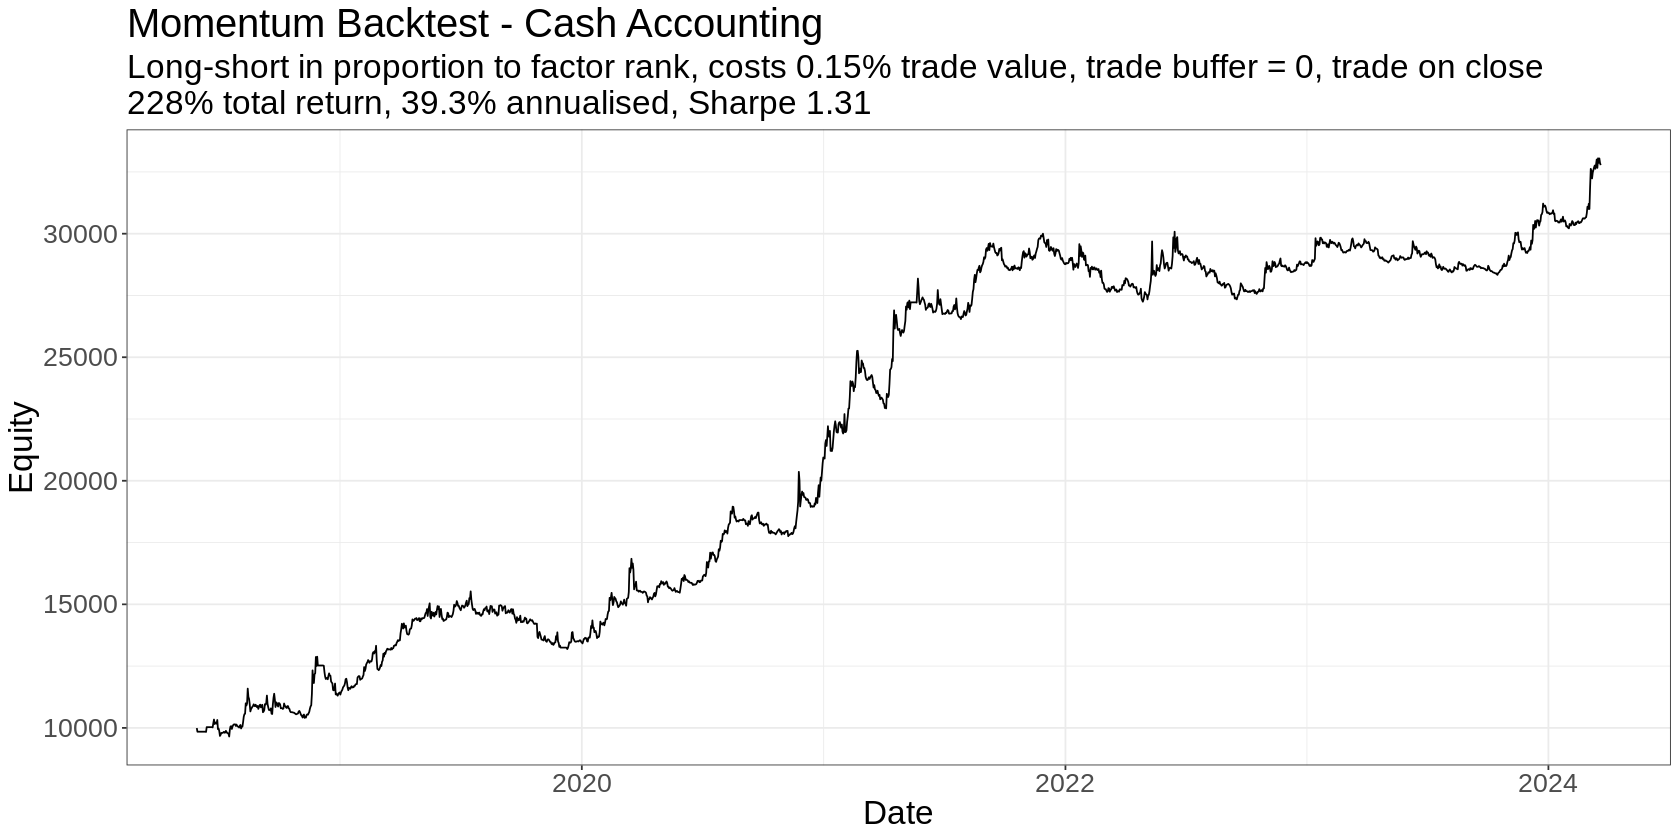

In [19]:
# simulation parameters
fee_tier <- 1.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(
  backtest_prices,
  backtest_weights,
  trade_buffer,
  initial_cash,
  commission_pct,
  capitalise_profits
)

results_df %>%
  plot_results()

Find an appropriate trade buffer parameter by optimising for sharpe ratio

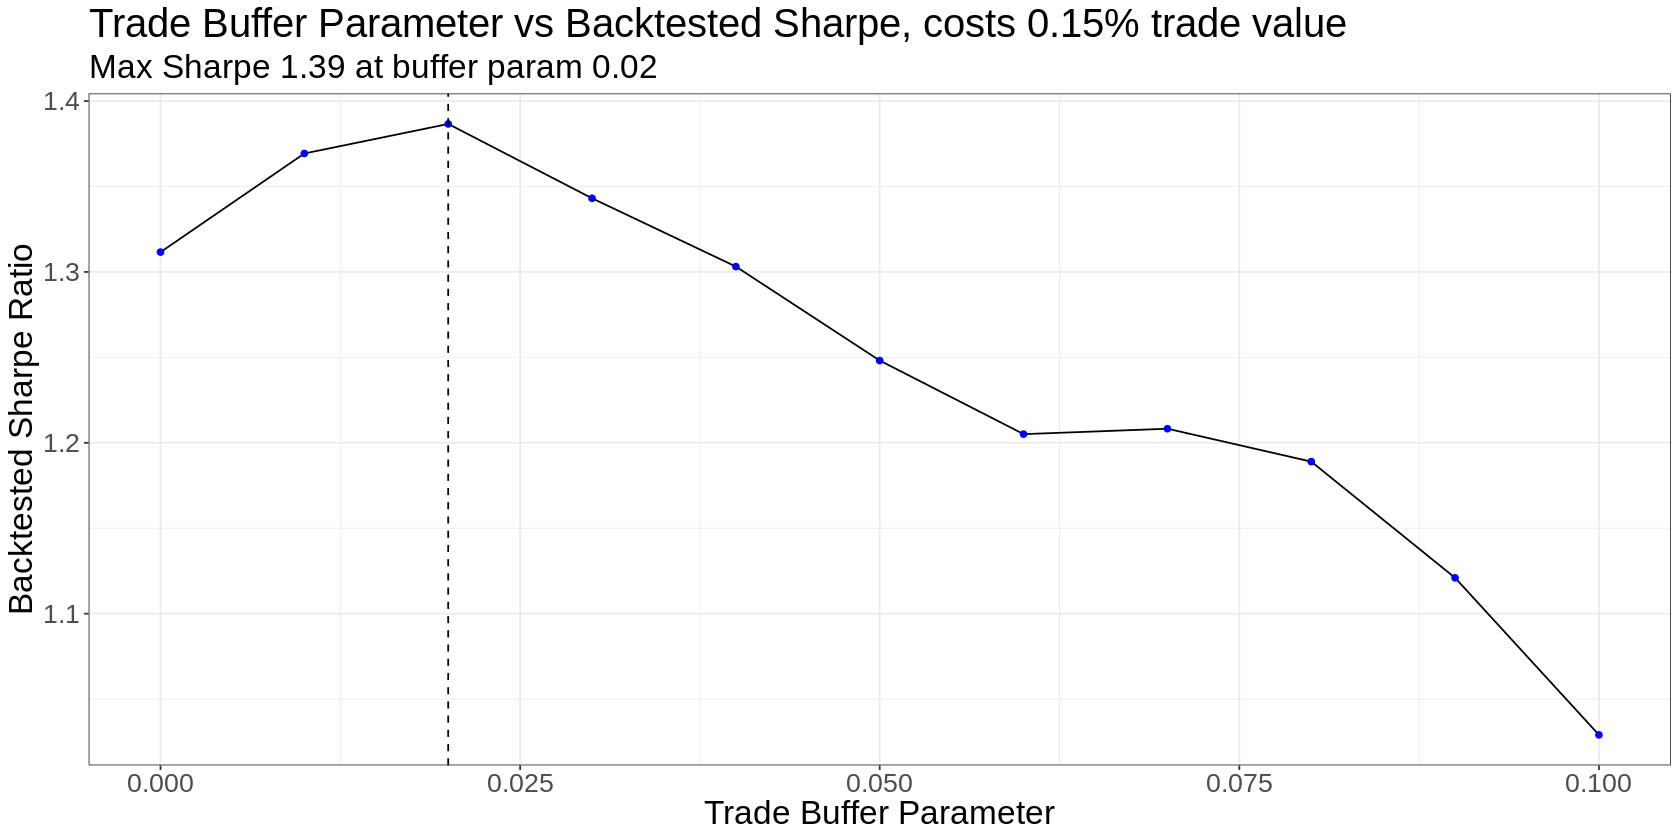

In [20]:
sharpes <- list()
trade_buffers <- seq(0, 0.1, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes,
    cash_backtest(
      backtest_prices,
      backtest_weights,
      trade_buffer,
      initial_cash,
      commission_pct,
      capitalise_profits
    ) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers,
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

Even with our slightly more hyperactive features, it's still optimal to have a small trade buffer (crypto is relatively cheap to trade).

Some of our coins will be more expensive to trade than others. In mid November 2023, the costs to trade the current universe on Binance's lowest tier were as follows:

|Ticker|Bid|Ask|Spread %|3xSpread|Commish|Total|Total with 3x spread|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|BTC|36395.99|36396|0.000%|0.00%|0.10%|0.100%|0.10%|
|ETH|1982.91|1982.92|0.001%|0.00%|0.10%|0.101%|0.10%|
|XRP|0.6196|0.6197|0.016%|0.05%|0.10%|0.116%|0.15%|
|ADA|0.3744|0.3745|0.027%|0.08%|0.10%|0.127%|0.18%|
|BNB|244|244.1|0.041%|0.12%|0.10%|0.141%|0.22%|
|SHIB|0.00000861|0.00000862|0.116%|0.35%|0.10%|0.216%|0.45%|
|LTC|70.61|70.62|0.014%|0.04%|0.10%|0.114%|0.14%|
|SOL|58.58|58.59|0.017%|0.05%|0.10%|0.117%|0.15%|
|TRX|0.10323|0.10324|0.010%|0.03%|0.10%|0.110%|0.13%|
|DOGE|0.08139|0.0814|0.012%|0.04%|0.10%|0.112%|0.14%|

The most expensive thing to trade (SHIB) would cost 0.216% in commissions and spread if you executed a market order for smallish volume.

So let's see what our trade buffer looks like if we treat everything as though it costs that much to trade:

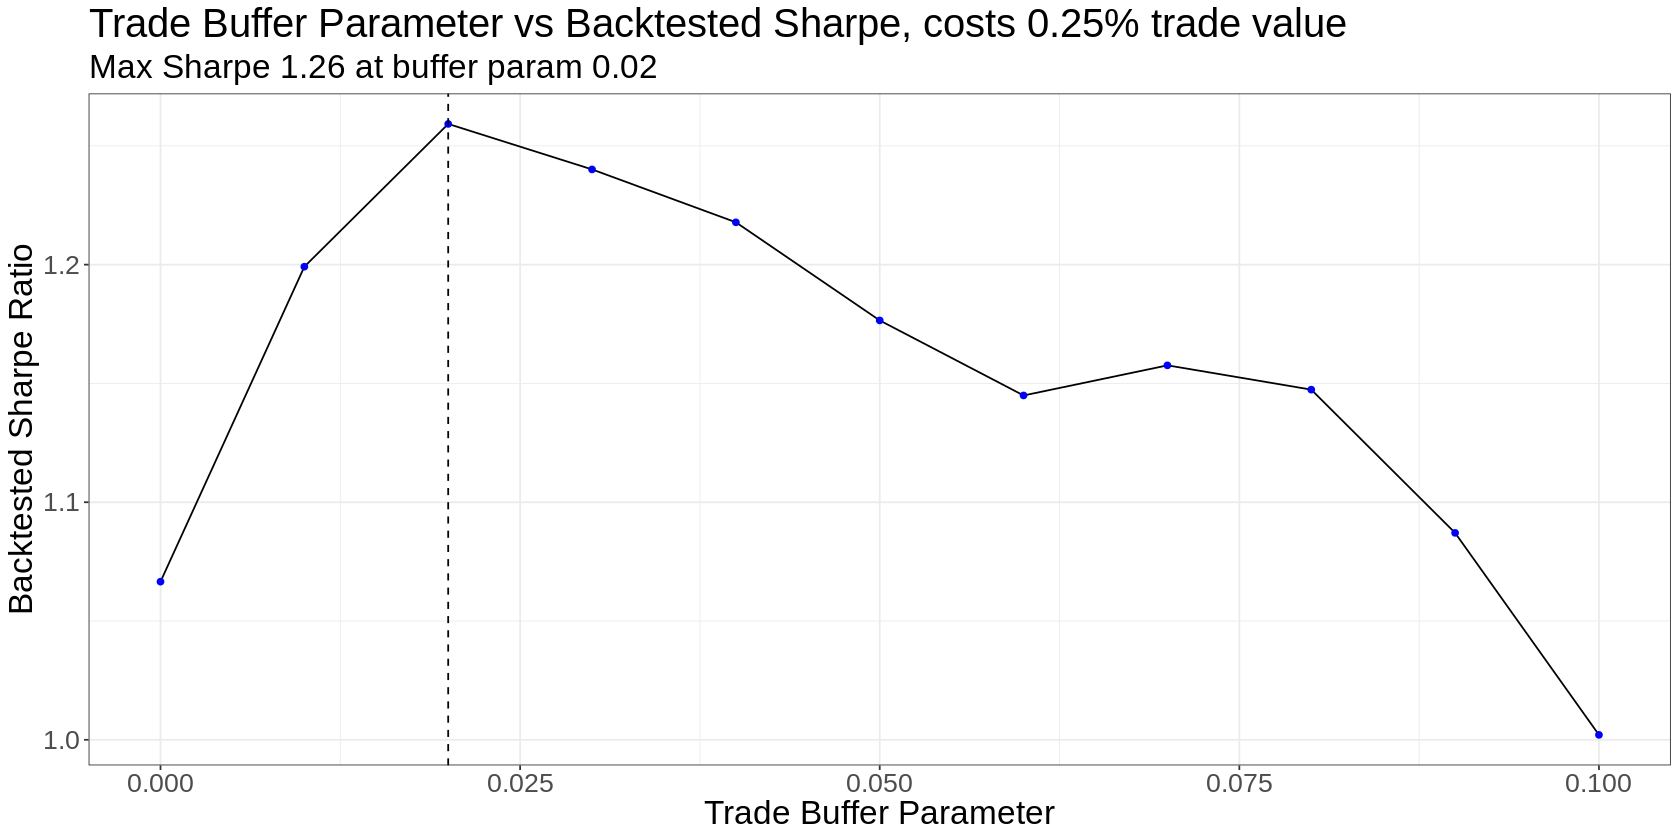

In [21]:
commission_pct <- 0.0025

sharpes <- list()
trade_buffers <- seq(0, 0.1, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes,
    cash_backtest(
      backtest_prices,
      backtest_weights,
      trade_buffer,
      initial_cash,
      commission_pct,
      capitalise_profits
    ) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers,
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

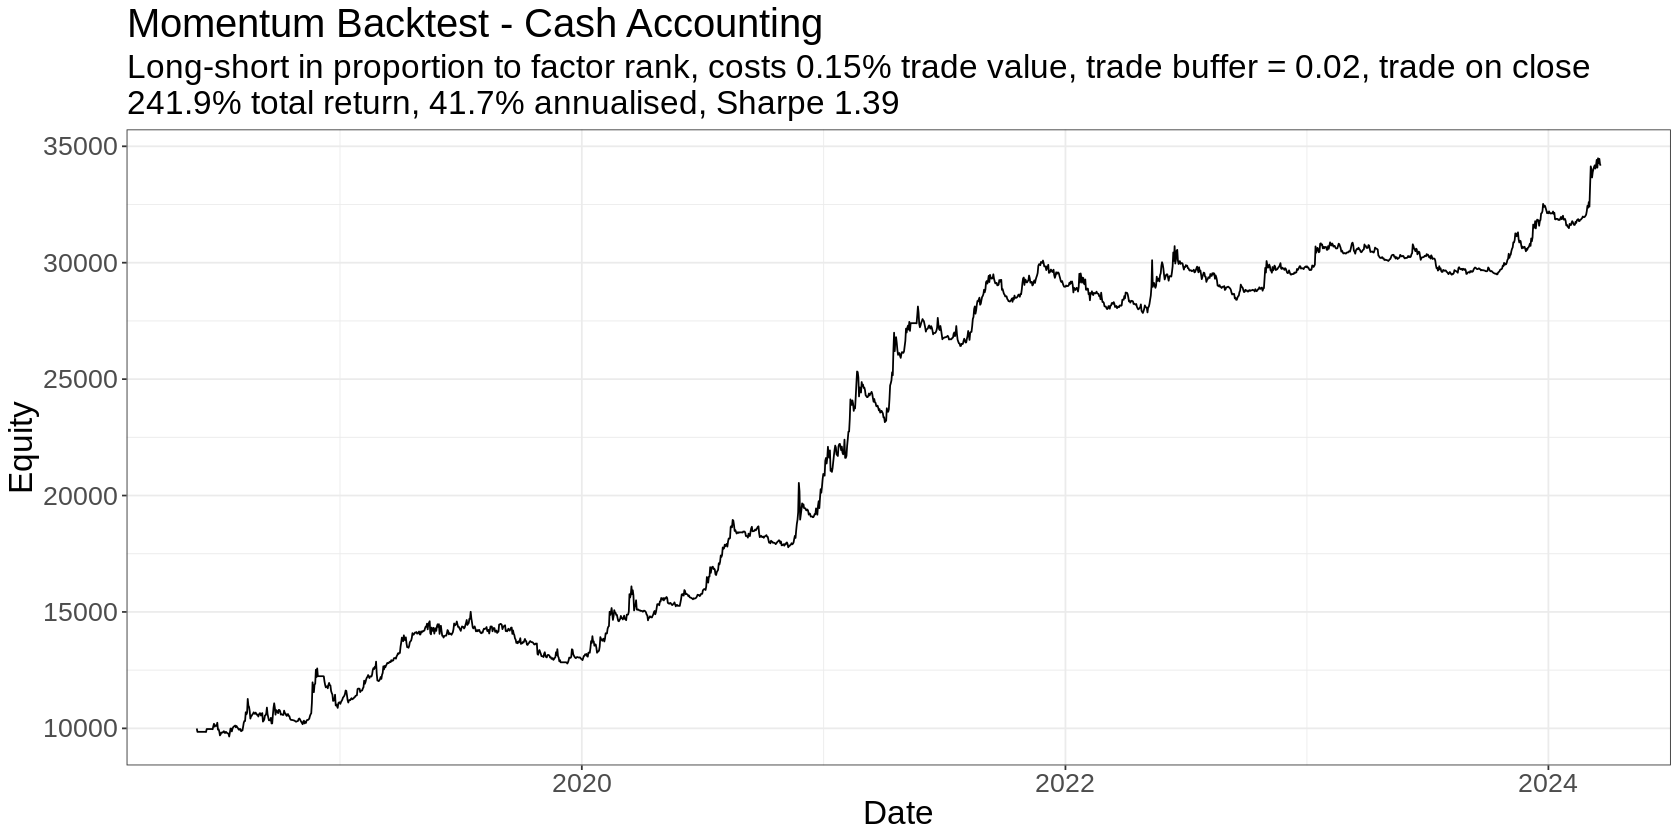

In [24]:
# get back original with costs simulation results
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.02
fee_tier <- 1.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(backtest_prices, backtest_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits) %>%
  mutate(ticker = str_remove(ticker, "Close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

# simulation results
results_df %>%
  plot_results()

Let's look at turnover.

### Turnover

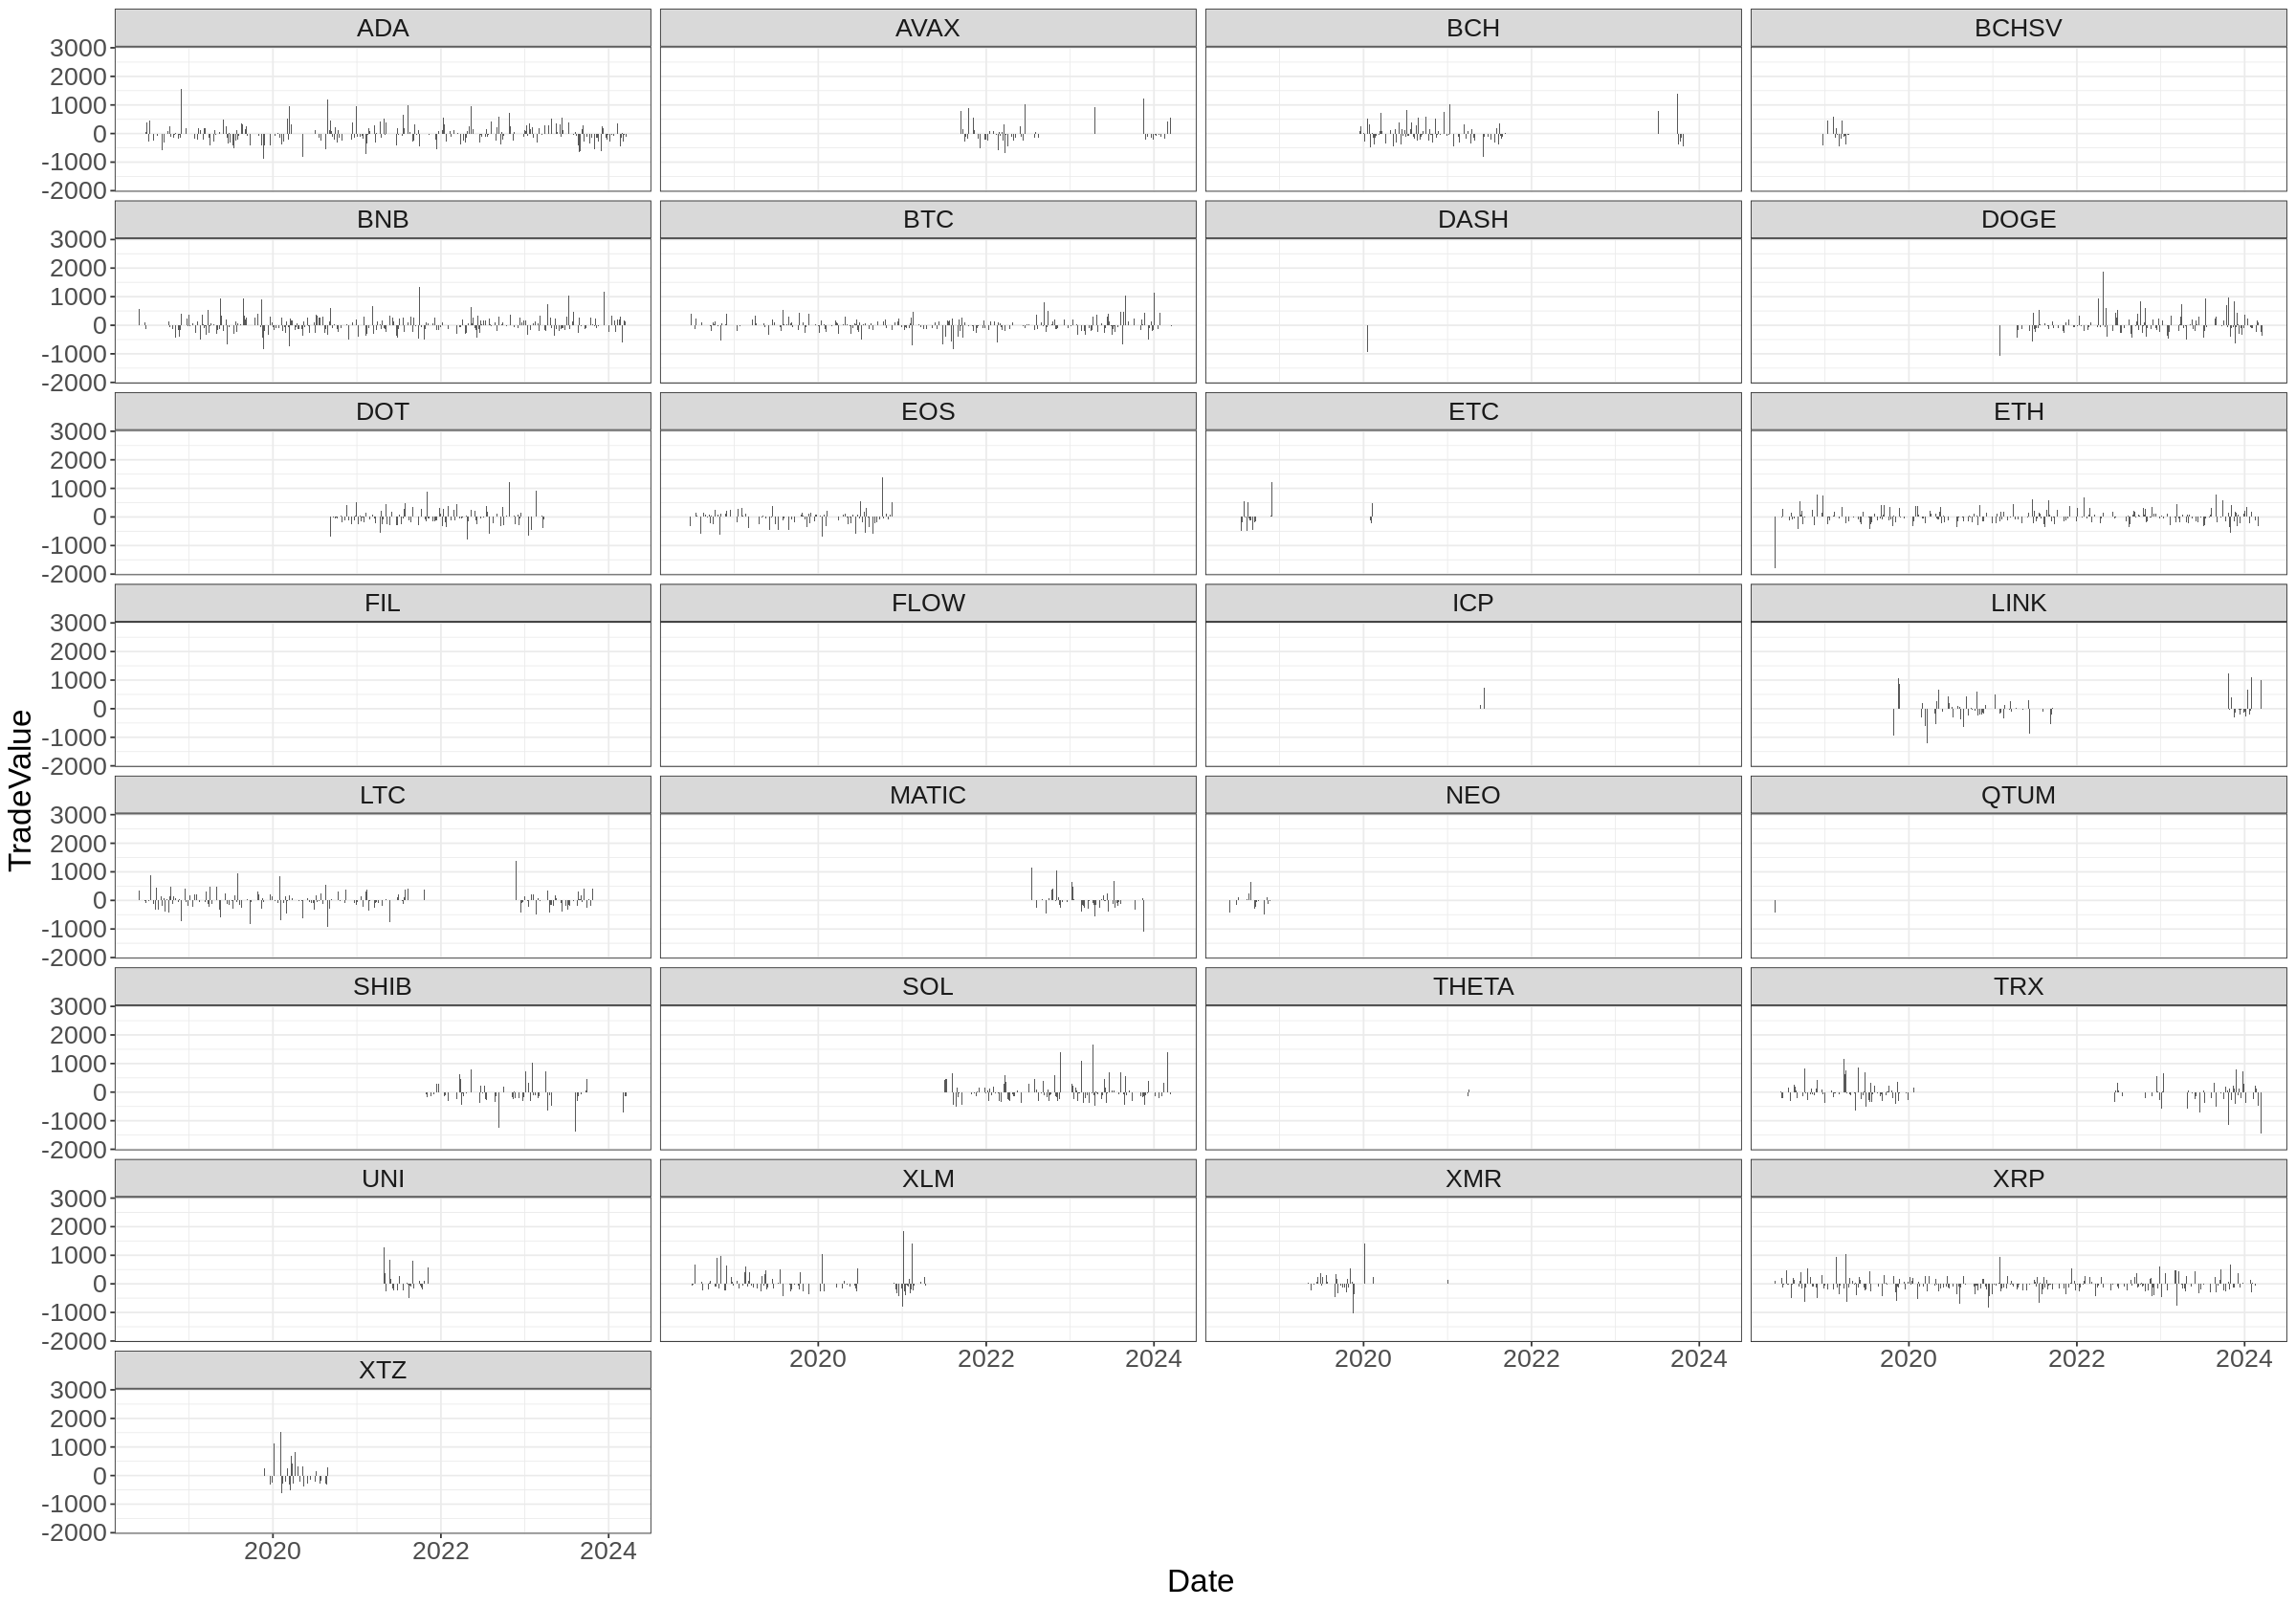

In [25]:
# need a bigger plot
options(repr.plot.width = 20, repr.plot.height=14)

results_df %>%
  filter(ticker != "Cash", abs(TradeValue) > 0) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 4)

# set back to default
options(repr.plot.width = 14, repr.plot.height=7)

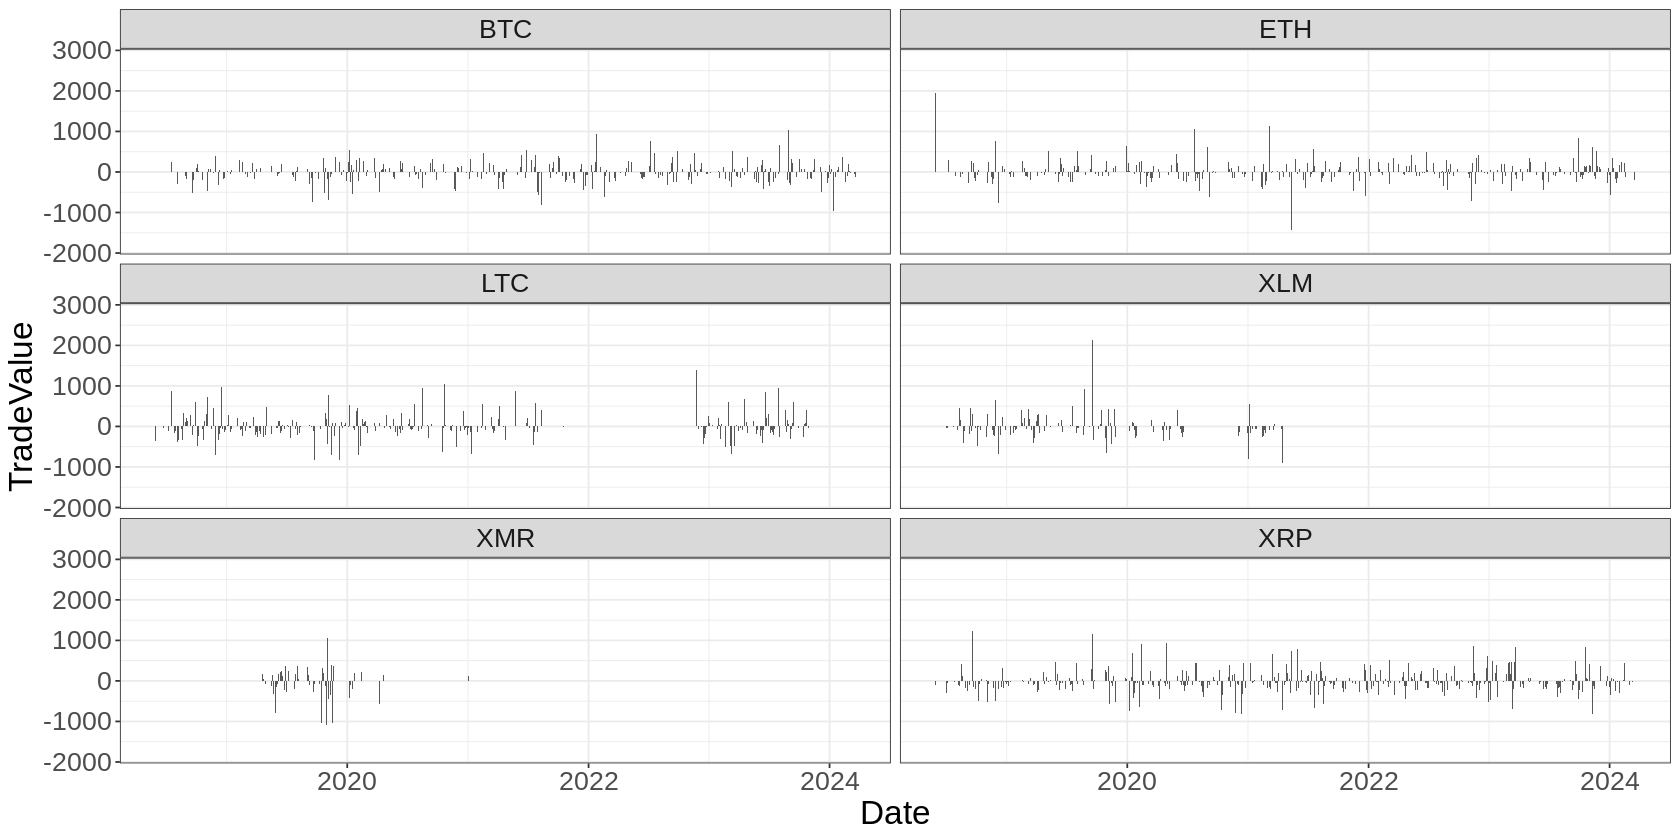

In [26]:
# major coins
results_df %>%
  filter(ticker %in% c("BTC", "ETH", "LTC", "XLM", "XMR", "XRP")) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 2)

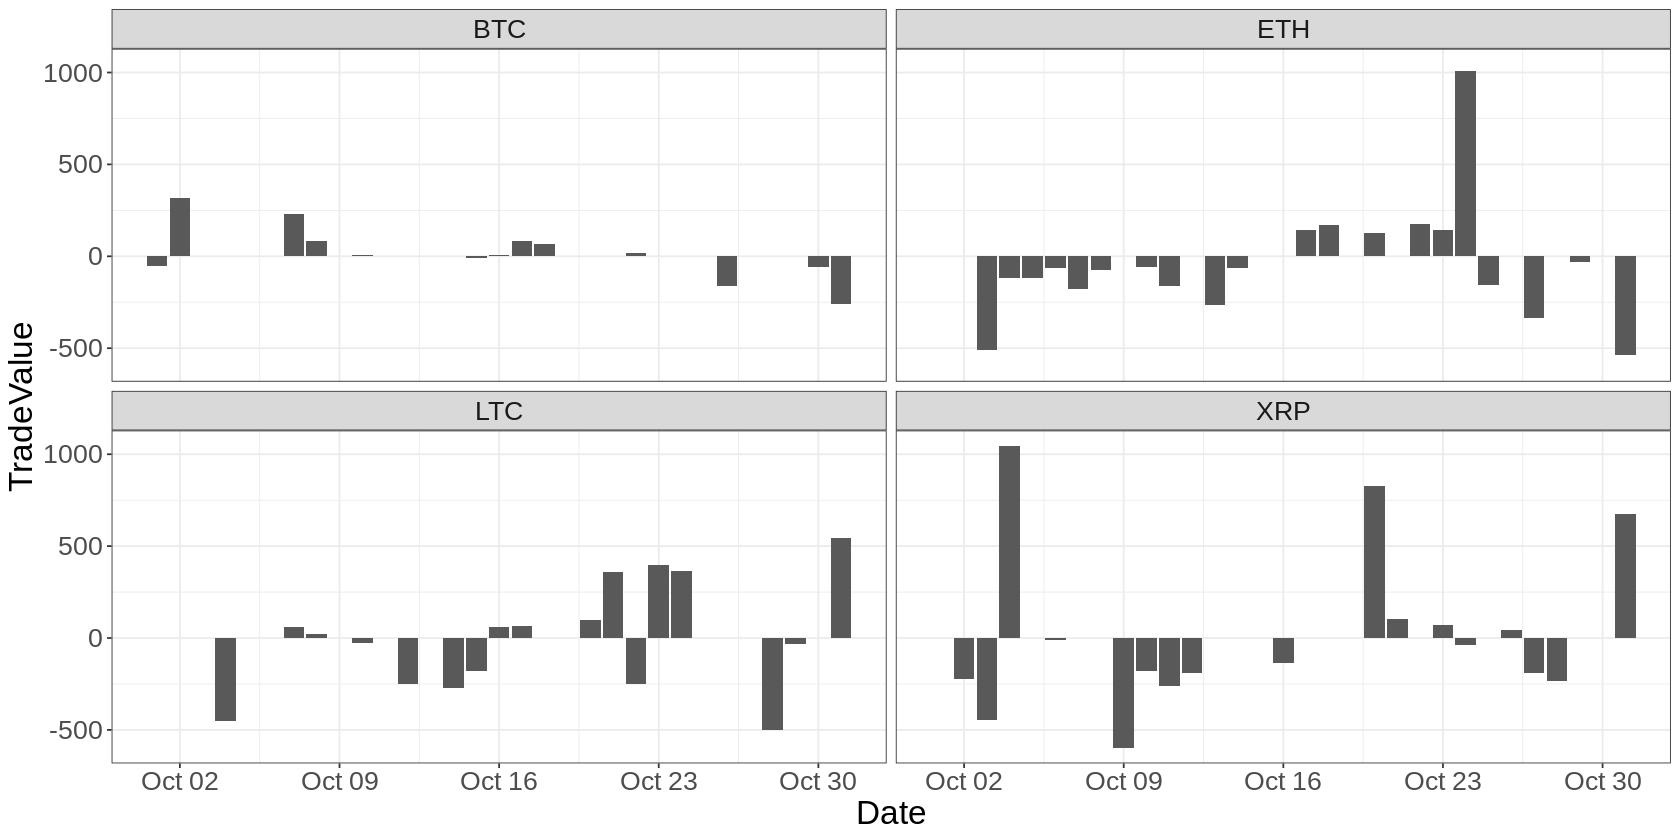

In [27]:
# zoomed in to a recent month
results_df %>%
  filter(
    ticker %in% c("BTC", "ETH", "LTC", "XRP"),
    Date >= "2023-10-01",
    Date < "2023-11-01"
  ) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 2)

Date,combo_weight_ADA,combo_weight_AVAX,combo_weight_BCH,combo_weight_BNB
19722,0.015336651,-0.04516564,0,0.14933612
19723,0.008289309,-0.06006050,0,0.13582730
19724,0.015849820,-0.05680052,0,0.08825731
19725,-0.003627008,-0.06927773,0,0.10371143
19726,-0.047780133,-0.06644570,0,0.12330530


Date,Close_ADA,Close_AVAX,Close_BCH,Close_BNB
19722,0.6046,40.04,266.6,322.1
19723,0.5994,38.77,264.9,311.3
19724,0.6324,43.13,268.0,319.6
19725,0.6137,40.95,263.6,318.7
19726,0.5577,36.61,234.6,320.1


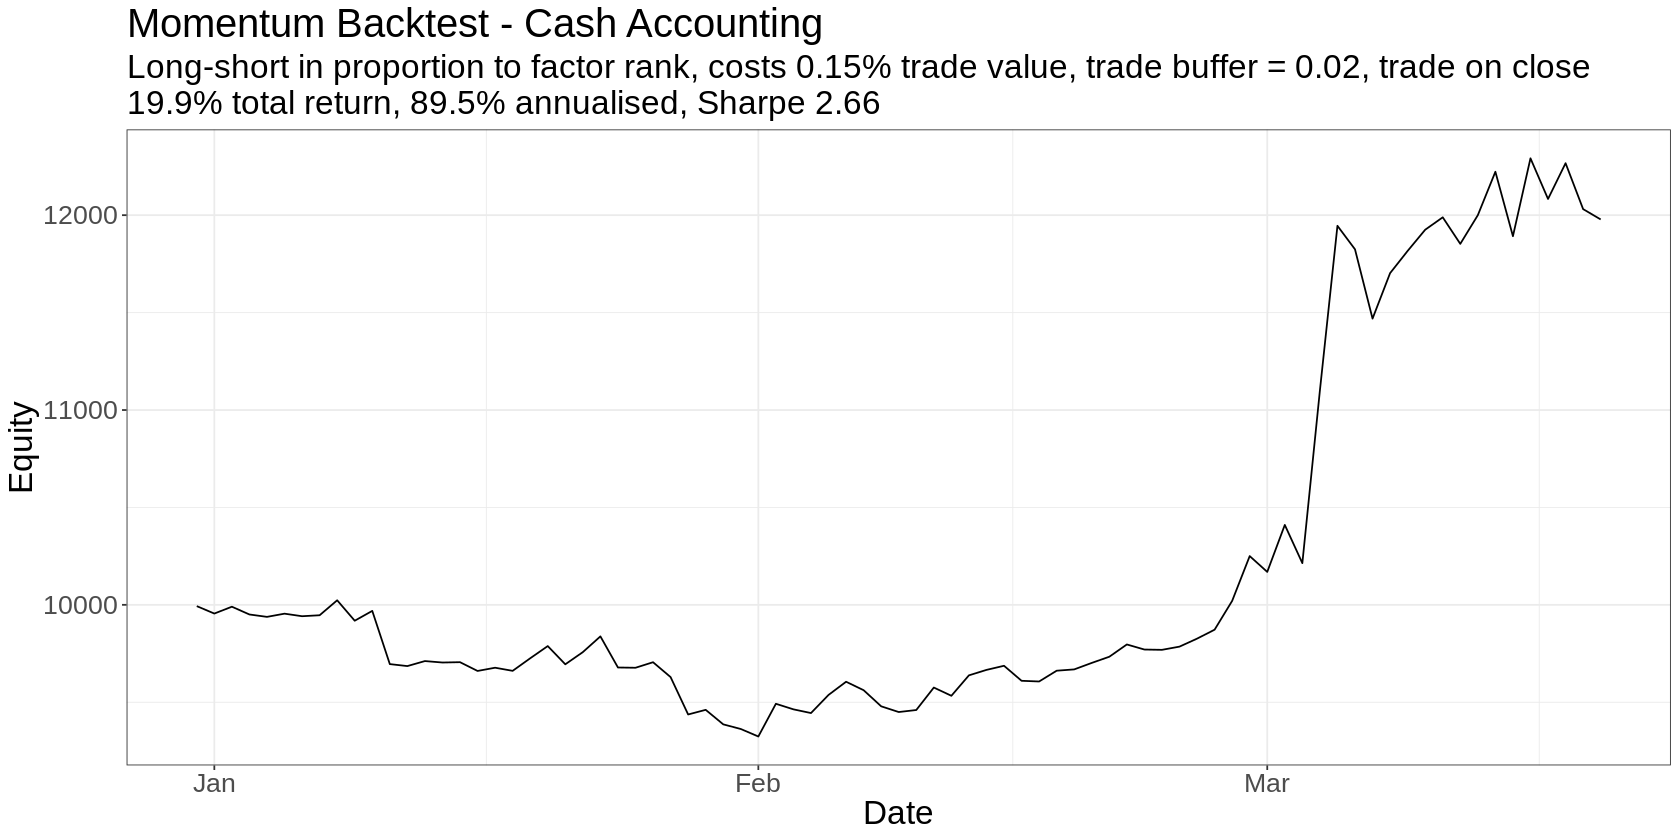

In [28]:
# 2024 only
# get weights as a wide matrix (could do equal weight, in proportion to factor/signal, top n etc)
# note that date column will get converted to unix timestamp
backtest_weights <- sim_df %>%
  filter(Date >= "2023-12-31") %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = c(Close, combo_weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(Date, starts_with("combo_weight")) %>%
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

head(backtest_weights, c(5, 5))

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- sim_df %>%
  filter(Date >= "2023-12-31") %>%
  pivot_wider(id_cols = Date, names_from = Ticker, values_from = c(Close, combo_weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(Date, starts_with("Close_")) %>%
  data.matrix()

head(backtest_prices, c(5, 5))

# simulation
results_df <- cash_backtest(backtest_prices, backtest_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits) %>%
  mutate(ticker = str_remove(ticker, "Close_")) %>%
  # remove coins we don't trade from results
  drop_na(Value)

# simulation results
results_df %>%
  plot_results()